In [1]:
import matplotlib, sys,  os
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['NUMEXPR_NUM_THREADS'] = '1'
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
sys.path.append("./mylib/")

import numpy as np
matplotlib.use('Agg')
import matplotlib.pyplot as plt

from threeML import *
from WCDA_hal import HAL, HealpixConeROI, HealpixMapROI
import traceback
import warnings
# warnings.simplefilter("ignore")
silence_warnings()
from threeML import silence_progress_bars, activate_progress_bars, toggle_progress_bars
from threeML.utils.progress_bar import trange

from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy import units as u
# from astropy.visualization import astropy_mpl_style, imshAow_norm
from astropy.coordinates import Angle

import healpy as hp

from tqdm import tqdm

# from mylib import *
import mylib as my
from importlib import reload

Welcome to JupyROOT 6.24/06


23:00:15 WARNING   The GSL library or the pygsl wrapper cannot be loaded. Models that depend on it  ]8;id=986027;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=78547;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/astromodels/functions/functions_1D/functions.py#71\71]8;;\
                  will not be available.                                                                           

/data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


23:00:16 INFO      Starting 3ML!                                                                     ]8;id=827847;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=453472;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/__init__.py#35\35]8;;\

         WARNING   WARNINGs here are NOT errors                                                      ]8;id=37774;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=47048;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/__init__.py#36\36]8;;\

         WARNING   but are inform you about optional packages that can be installed                  ]8;id=809607;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=876668;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/__init__.py#37\37]8;;\

         WARNING    to disable these messages, turn off start_warning in your config file            ]8;id=321551;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=465577;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/__init__.py#40\40]8;;\

23:00:17 WARNING   The cthreeML package is not installed. You will not be able to use plugins which  ]8;id=866306;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=495699;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/__init__.py#94\94]8;;\
                  require the C/C++ interface (currently HAWC)                                                     

         WARNING   Could not import plugin FermiLATLike.py. Do you have the relative instrument     ]8;id=716961;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=852935;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/__init__.py#144\144]8;;\
                  software installed and configured?                                                               

         WARNING   Could not import plugin HAWCLike.py. Do you have the relative instrument         ]8;id=565408;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=142234;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/__init__.py#144\144]8;;\
                  software installed and configured?                                                               

23:00:17 WARNING   No fermitools installed                                              ]8;id=617958;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=91163;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/utils/data_builders/fermi/lat_transient_builder.py#44\44]8;;\

Load Mymap:  11%|█         | 4/37 [00:00<00:00, 333.28it/s]     
WARNING VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.


WARNING RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 96, got 80


WARNING RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 232, got 216

ReLoad Mycatalog:  59%|█████▉    | 22/37 [00:00<00:00, 34.26it/s] 
WARNING VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.

Load sub from Myspeedup: 100%|██████████| 37/37 [00:00<00:00, 117.08it/s]   

Yourlib init successfully!!!


In [4]:
%matplotlib inline
#####   Data Initialize
# activate_warnings()

# maptree = "../../data/gcd_new.root"
# response="../../data/WCDA_DR_psf.root"

# maptree =  "../../data/hsc2healpix_20210305_20220930.root"
# response = "../../data/WCDA_DR2.root"

# maptree =  "../../data/20210305_20230731_ihep_no_goodlist.root"
# response = "../../data/DR_ihep_MK2.root"

# maptree =  "../../data/20210305_20230731_ihep_goodlist.root"
# response = "../../data/DR_ihep_MK2_newpsf.root"

maptree =  "../../data/20210305-20230731_trans_fromhsc.root"
response = "../../data/DR_ihep_MK2_newoldDRpsf.root"


region_name="Diffuse_WCDA_case11"
if not os.path.exists(f'../res/{region_name}/'):
    os.system(f'mkdir ../res/{region_name}/')


nside=2**10
npix=hp.nside2npix(nside)
pixarea = 4 * np.pi/npix
pixIdx = hp.nside2npix(nside) # number of pixels I can get from this nside
pixIdx = np.arange(pixIdx) # pixel index numbers
new_lats = hp.pix2ang(nside, pixIdx)[0] # thetas I need to populate with interpolated theta values
new_lons = hp.pix2ang(nside, pixIdx)[1] # phis, same
c_icrs = SkyCoord(ra=new_lons*180/np.pi*u.degree, dec=90*u.degree-new_lats*180/np.pi*u.degree, frame='icrs')
c_l=c_icrs.galactic.l.deg
c_b=c_icrs.galactic.b.deg

resultsall = []
for i,gl in enumerate([120]): # #!!!!!!!!!!!!!!!!!!!365  range(20,360,10)
    c_gal = SkyCoord(l=(gl)*u.degree, b=0*u.degree, frame='galactic')
    RA_center=c_gal.icrs.ra.deg
    Dec_center=c_gal.icrs.dec.deg
    if (Dec_center<-20. or Dec_center>80.): continue
    signal=np.zeros(npix,dtype=np.float64)
    mask = ( (c_l< gl + 5) & (c_l > gl - 5) & (c_b <5.) & (c_b>-5) & (90-new_lats/np.pi*180>-20) & (90-new_lats/np.pi*180<80)) #&(new_lats<110/180*np.pi )  & (new_lats > 10/180*np.pi )
        
    signal[mask]=1
    # hp.mollview(signal,title="ROI",norm='hist')
    # hp.graticule()
    ra1,dec1=RA_center, Dec_center

    data_radius = 7
    model_radius = 7.5

    roi = HealpixMapROI(ra=ra1,dec=dec1, data_radius=data_radius, model_radius=model_radius, roimap=signal)

    WCDA = HAL("WCDA", maptree, response, roi, flat_sky_pixels_size=0.17)

    #####   Data Situation
    %matplotlib inline
    WCDA.set_active_measurements(0, 5)
    WCDA.display()
    WCDA.psf_integration_method="exact"

    my.settransWCDA(WCDA, ra1, dec1)

    Modelname=f"roi_{gl - 5}-{gl + 5}"
    if not os.path.exists(f'../res/{region_name}/{Modelname}/'):
        os.system(f'mkdir ../res/{region_name}/{Modelname}/')
    fig = WCDA.display_stacked_image(smoothing_kernel_sigma=0.25)
    fig.savefig(f"../res/{region_name}/{Modelname}_counts_all.png",dpi=300)

    lm = my.getcatModel(ra1, dec1, data_radius, model_radius, rtsigma=5, rtflux=20, rtindex=10, rtp=5,  detector="WCDA", roi=roi, pf=True, sf=True, kf=False, indexf=False,  mkf=True, mindexf=True,  setdeltabypar=True, setdeltabypar=False) #indexb=(-4,-1),

    Diffuse, diffscaleratio = my.set_diffusebkg(
                ra1, dec1, 8, 8, Kf=False, indexf=False, name=region_name, ifreturnratio=True, Kb=(1e-18, 1e-10), indexb=(-4.5, -0.5), index=-2.5, setdeltabypar=False
                ) #Kn=1 , K=1e-12
    
    lm.add_source(Diffuse)

    lm.save(f"../res/{region_name}/{Modelname}/Model_init.yml", overwrite=True)
    lm.display(complete=True)

    result = my.fit(region_name, Modelname, WCDA, lm, 0, 5, mini="ROOT", donwtlimit=True) #, ifgeterror=True
    sources = my.get_sources(lm,result)
    resultsall.append([result, sources, diffscaleratio])

    resu = my.getressimple(WCDA, lm)
    new_source_idx = np.where(resu==np.ma.max(resu))[0][0]
    new_source_lon_lat=hp.pix2ang(1024,new_source_idx,lonlat=True)
    print(new_source_lon_lat)

    plt.figure()
    hp.gnomview(resu,norm='',rot=[ra1,dec1],xsize=200,ysize=200,reso=6,title=Modelname)
    plt.scatter(new_source_lon_lat[0],new_source_lon_lat[1],marker='x',color='red')
    plt.show()
    plt.savefig(f"../res/{region_name}/{Modelname}_res.png",dpi=300)

    map2, skymapHeader = hp.read_map("../../data/fullsky_WCDA_llh-2.6.fits.gz",h=True)
    map2 = my.maskroi(map2, roi)
    sources.pop("Diffuse")
    fig = my.drawmap(region_name, Modelname, sources, map2, ra1, dec1, rad=2*data_radius, contours=[10000],save=1, 
                    color="Fermi",
                    colors = my.colorall
                    )
    # try:
    Flux_WCDA0, jls0  = my.getdatapoint(WCDA, lm, maptree, response, roi, "Diffuse", ifpowerlawM=1, iffixtans=1)
    import matplotlib as mpl

    x_Max=50.
    x_Min=1
    y_Min=0.8e-13
    y_Max=2e-10
    fig,ax = plt.subplots()
    plot_spectra(
        result[0].results,
        sources_to_use=["Diffuse"], #,"ext1","ext2","ext4","ext5","ext6","ext7"|
        include_extended=True,
        ene_min=x_Min,
        ene_max=x_Max,
        num_ene=30,
        energy_unit="TeV",
        flux_unit="TeV/(s cm2)",
        subplot=ax,
        )

    my.Draw_sepctrum_points(region_name, Modelname, Flux_WCDA0,"Diffuse","tab:red")

    ax.set_xlim(x_Min,x_Max)
    ax.set_ylim(y_Min,y_Max)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylabel(r"$E^2\,dN/dE$ [TeV cm$^{-2}$ s$^{-1}$]")
    ax.set_xlabel("Energy [TeV]")
    plt.legend()
    plt.savefig(f'../res/{region_name}/{Modelname}/Spectrum.png', dpi=300)
    plt.savefig(f'../res/{region_name}/{Modelname}/Spectrum.pdf')
    # except:   pass
    #     continue

roi_15-25


processing MLE analyses:   0%|          | 0/1 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/30 [00:00<?, ?it/s]


WARNING UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.



roi_25-35


processing MLE analyses:   0%|          | 0/1 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/30 [00:00<?, ?it/s]


WARNING UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.



roi_35-45


processing MLE analyses:   0%|          | 0/1 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/30 [00:00<?, ?it/s]


WARNING UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.



roi_45-55


processing MLE analyses:   0%|          | 0/1 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/30 [00:00<?, ?it/s]


WARNING UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.



roi_55-65


processing MLE analyses:   0%|          | 0/1 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/30 [00:00<?, ?it/s]


WARNING UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.



roi_65-75


processing MLE analyses:   0%|          | 0/1 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/30 [00:00<?, ?it/s]


WARNING UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.



roi_75-85


processing MLE analyses:   0%|          | 0/1 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/30 [00:00<?, ?it/s]


WARNING UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.



roi_85-95
roi_95-105
roi_105-115
roi_115-125
roi_125-135
roi_135-145
roi_145-155
roi_155-165
roi_165-175
roi_175-185
roi_185-195
roi_195-205
roi_205-215
roi_215-225
roi_225-235


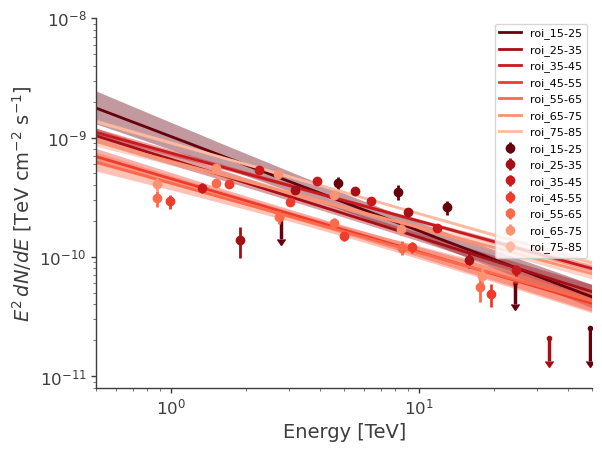

In [16]:
%matplotlib inline
import glob
gc = []
dk = []
dkf = []
de = []
di = []
die = []
den = []
dep = []
dien = []
diep = []
ss = []
ssr= []
x_Max=50.
x_Min=0.5
y_Min=0.8e-11
y_Max=1e-8
fig,ax = plt.subplots()
folder_path = f"/data/home/cwy/Science/3MLWCDA/Standard/res/{region_name}"
subfolders = glob.glob(folder_path + '/**/', recursive=True)
sorted_files = sorted(subfolders[1:], key=lambda x: int(x.split('_')[-1].split('-')[-2]))
# 打印所有找到的子文件夹路径
for i,subfolder in enumerate(sorted_files): #[:7]
    name = subfolder.split("/")[-2]
    print(name)
    specpath = subfolder+"Results.fits"
    resultsss = load_analysis_results(specpath)
    resultdict = resultsss.get_data_frame()
    gc.append(range(20,360,10)[i])
    dk.append(resultdict.loc["Diffuse.spectrum.main.Powerlaw.K"]["value"])
    de.append(resultdict.loc["Diffuse.spectrum.main.Powerlaw.K"]["error"])
    den.append(abs(resultdict.loc["Diffuse.spectrum.main.Powerlaw.K"]["negative_error"]))
    dep.append(abs(resultdict.loc["Diffuse.spectrum.main.Powerlaw.K"]["positive_error"]))
    di.append(resultdict.loc["Diffuse.spectrum.main.Powerlaw.index"]["value"])
    die.append(resultdict.loc["Diffuse.spectrum.main.Powerlaw.index"]["error"])
    dien.append(abs(resultdict.loc["Diffuse.spectrum.main.Powerlaw.index"]["negative_error"]))
    diep.append(abs(resultdict.loc["Diffuse.spectrum.main.Powerlaw.index"]["positive_error"]))
    try:
        dkf.append(resultsall[i][2][0])
    except:
        resultfile = np.load(f"../res/{region_name}/resultsall.npy")
        dkf = resultfile[9]
    if i < 7:
        # try:
        plot_spectra(
            resultsss,
            sources_to_use=["Diffuse"],
            include_extended=True,
            ene_min=x_Min,
            ene_max=x_Max,
            num_ene=30,
            energy_unit="TeV",
            flux_unit=f"TeV/(s cm2)", #*
            subplot=ax,
            plot_style_kwargs={"label":name, "color":my.red_palette[-(i+1)], "scale":1/dkf[i]} #
            )
        try:
            data = my.Draw_spectrum_fromfile(subfolder+"Spectrum_Diffuse.txt", label=name, color=my.red_palette[-(i+1)], subplot=ax, scale=1/dkf[i])
            my.spec2naima(f"./spec_{name}.txt", data)
        except:
            pass
        # except Exception as e:
        #     print(f"Error: {e}")
        #     continue
results=[gc,dk,de,den,dep,di,die,dien,diep, dkf]
np.save(f"../res/{region_name}/resultsall.npy",results)
from threeML.analysis_results import AnalysisResultsSet
resultsall
rrr = [it[0][0].results for it in resultsall]
analysis_set = AnalysisResultsSet(rrr)

ax.set_xlim(x_Min,x_Max)
ax.set_ylim(y_Min,y_Max)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel(r"$E^2\,dN/dE$ [TeV cm$^{-2}$ s$^{-1}$]")
ax.set_xlabel("Energy [TeV]")
ax.legend()
plt.savefig(f"../res/{region_name}/spectrum_band10-70.png",dpi=300)
plt.savefig(f"../res/{region_name}/spectrum_band10-70.pdf",dpi=300)

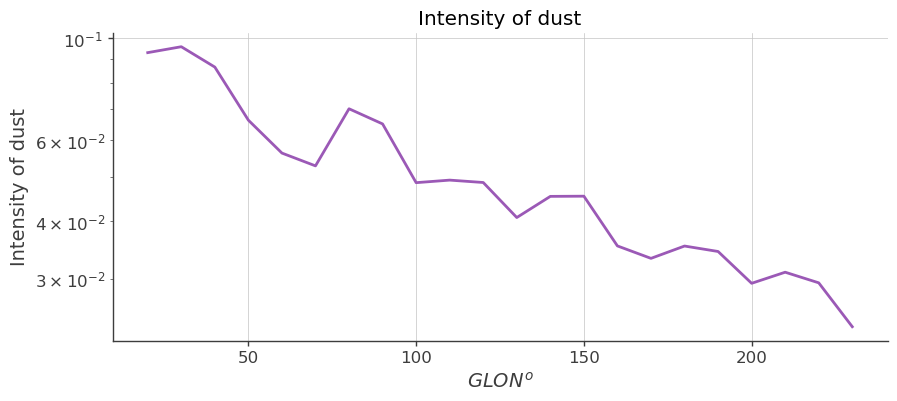

In [4]:
plt.figure(figsize=(10,4)) #
plt.plot(gc, np.array(dkf)) #np.array(den)*1e9, np.array(dep)*1e9 , fmt="o"
plt.yscale("log")
plt.title("Intensity of dust")

plt.ylabel(r"Intensity of dust")
# plt.ylim(1e-7, 1e-4)
plt.grid()
plt.xlabel(r"$GLON^{o}$")
plt.savefig(f"../res/{region_name}/dust.png",dpi=300)
plt.savefig(f"../res/{region_name}/dust.pdf",dpi=300)

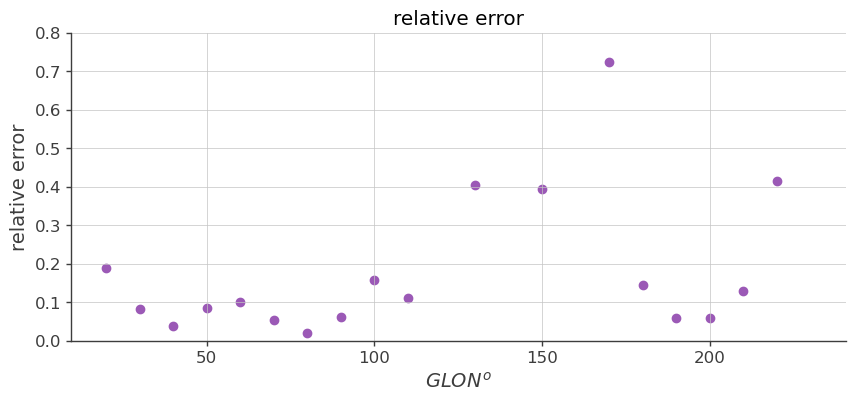

In [15]:
plt.figure(figsize=(10,4)) #
plt.scatter(gc, (np.array(de)*1e9)/(np.array(dk)*1e9), marker="o") #np.array(den)*1e9, np.array(dep)*1e9
# plt.yscale("log")
plt.title("relative error")
plt.ylim(0, 0.8)
plt.ylabel("relative error")
plt.grid()
plt.xlabel(r"$GLON^{o}$")
plt.savefig(f"../res/{region_name}/flux.png",dpi=300)
plt.savefig(f"../res/{region_name}/flux.pdf",dpi=300)

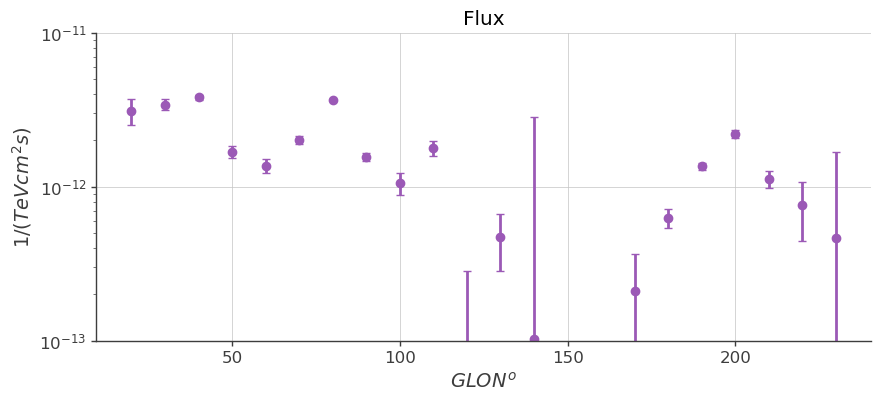

In [5]:
plt.figure(figsize=(10,4)) #
plt.errorbar(gc, np.array(dk)*1e9, [np.array(de)*1e9, np.array(de)*1e9], fmt="o", capsize=3) #np.array(den)*1e9, np.array(dep)*1e9
plt.yscale("log")
plt.title("Flux")
plt.ylim(1e-13, 1e-11)
plt.ylabel(r"$1/(TeV cm^{2} s)$")
plt.grid()
plt.xlabel(r"$GLON^{o}$")
plt.savefig(f"../res/{region_name}/flux.png",dpi=300)
plt.savefig(f"../res/{region_name}/flux.pdf",dpi=300)

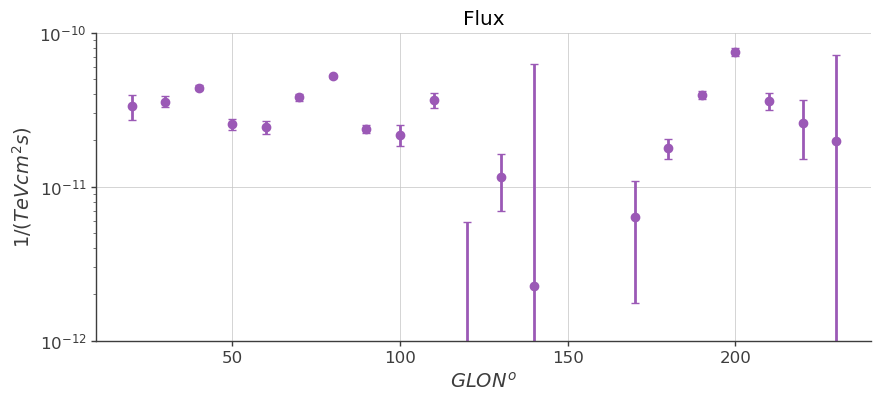

In [6]:
plt.figure(figsize=(10,4)) #
plt.errorbar(gc, np.array(dk)*1e9/np.array(dkf), [np.array(de)*1e9/np.array(dkf), np.array(de)*1e9/np.array(dkf)], fmt="o", capsize=3) #np.array(den)*1e9, np.array(dep)*1e9
plt.yscale("log")
plt.title("Flux")
plt.ylim(1e-12, 1e-10)
plt.ylabel(r"$1/(TeV cm^{2} s)$")
plt.grid()
plt.xlabel(r"$GLON^{o}$")
plt.savefig(f"../res/{region_name}/flux_fullsky.png",dpi=300)
plt.savefig(f"../res/{region_name}/flux_fullsky.pdf",dpi=300)

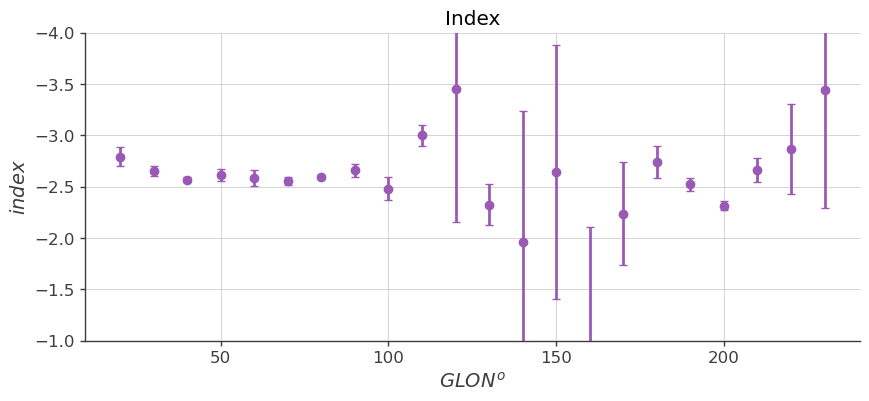

In [7]:
plt.figure(figsize=(10,4)) #
plt.errorbar(gc, di, [die, die], fmt="o", capsize=3) #dien, diep
plt.ylim(-1,-4)
plt.title("Index")
plt.ylabel(r"$index$")
plt.xlabel(r"$GLON^{o}$")
plt.grid()
plt.savefig(f"../res/{region_name}/index.png",dpi=300)
plt.savefig(f"../res/{region_name}/index.pdf",dpi=300)

In [ ]:
%matplotlib inline
import glob
x_Max=50.
x_Min=0.5
y_Min=0.8e-11
y_Max=1e-8
fig,ax = plt.subplots()
folder_path = f"/data/home/cwy/Science/3MLWCDA/Standard/res/{region_name}"
subfolders = glob.glob(folder_path + '/**/', recursive=True)
sorted_files = sorted(subfolders[1:], key=lambda x: int(x.split('_')[-1].split('-')[-2]))
# 打印所有找到的子文件夹路径
for i,subfolder in enumerate(sorted_files[6:14]):
    name = subfolder.split("/")[-2]
    print(name)
    specpath = subfolder+"Results.fits"
    resultsss = load_analysis_results(specpath)
    # try:
    plot_spectra(
        resultsss,
        sources_to_use=["Diffuse"],
        include_extended=True,
        ene_min=x_Min,
        ene_max=x_Max,
        num_ene=30,
        energy_unit="TeV",
        flux_unit=f"TeV/(s cm2)", #*
        subplot=ax,
        plot_style_kwargs={"label":name, "color":my.red_palette[-(i+1)], "scale":1/dkf[i+6]} #
        )
    # except Exception as e:
    #     print(f"Error: {e}")
    #     continue
    

ax.set_xlim(x_Min,x_Max)
ax.set_ylim(y_Min,y_Max)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel(r"$E^2\,dN/dE$ [TeV cm$^{-2}$ s$^{-1}$]")
ax.set_xlabel("Energy [TeV]")
ax.legend()
plt.savefig(f"../res/{region_name}/spectrum_band70-150.png",dpi=300)
plt.savefig(f"../res/{region_name}/spectrum_band70-150.pdf",dpi=300)